# Wine Quality NoteBook

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 


import matplotlib.pyplot as plt
import math


# Prepare Data

In [3]:
df = pd.read_csv('winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
labels = np.unique(df['type'].values)
idx_to_labels = { k:v for k,v in enumerate(labels) }
labels_to_idx = { v:k for k,v in enumerate(labels) }

In [5]:
labels = df.replace(labels_to_idx)['type'].values
df = df.drop(columns=['type'])

# one hot encoding
labels = np.eye(len(idx_to_labels))[labels]

In [23]:
# normalized data
df = (df-df.mean())/df.std()

# replace NaN with Standard Deviation
df = df.fillna(df.mean())

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.168556,-0.424502,0.283696,3.205929,-0.315457,0.815503,0.959902,2.102052,-1.360004,-0.546365,-1.418449,0.207983
1,-0.708368,-0.242296,0.146016,-0.808258,-0.201289,-0.931035,0.287595,-0.232314,0.506269,-0.277573,-0.831551,0.207983
2,0.679719,-0.363766,0.559055,0.305626,-0.172747,-0.029596,-0.331634,0.134515,0.257433,-0.613563,-0.328496,0.207983
3,-0.014324,-0.667443,0.008337,0.641893,0.055590,0.928182,1.242978,0.301255,-0.178031,-0.882354,-0.496181,0.207983
4,-0.014324,-0.667443,0.008337,0.641893,0.055590,0.928182,1.242978,0.301255,-0.178031,-0.882354,-0.496181,0.207983


In [24]:
features = df.values

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

# Parameters

In [26]:
gamma = {}
gamma["ndims"] = features.shape[1]
gamma["nclasses"] = len(idx_to_labels.values())

# Generate Weights

In [27]:
np.random.seed(1337)
def generate_weights(gamma):
    '''
        Generate Weights and use Xavier Initiation
    '''
    scale = 1/max(1., (2+2)/2.)
    limit = math.sqrt(3.0 * scale)

    gamma['w0'] = np.random.uniform(-limit, limit, size=(gamma['ndims'], gamma['ndims']))
    gamma['w1'] = np.random.uniform(-limit, limit, size=(gamma['ndims'], gamma['nclasses']))
    
    return gamma

In [28]:
gamma = generate_weights(gamma)
print('w0 shape:', gamma['w0'].shape, ' - w1 shape:', gamma['w1'].shape)

w0 shape: (12, 12)  - w1 shape: (12, 2)


# Activation Function and Derivative

In [29]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def dsigmoid(x):
    return x * (1. - x)

# Training

In [30]:
def loss(y, y_hat):
    '''
        Addition of all Squared Mean Errors
    '''
    return np.sum(np.mean(np.square(np.subtract(y, y_hat)), axis=0))

In [31]:
def forward(X, gamma):
    '''
        Forward Propagation
    '''
    l0 = X
    l1 = sigmoid(np.dot(l0, gamma['w0']))
    l2 = sigmoid(np.dot(l1, gamma['w1']))
    
    return l0, l1, l2

In [32]:
def backward(y, theta, gamma, lr):
    '''
        Backward Propagation
    '''
    l0, l1, l2 = theta
    
    l2_error = y - l2
    l2_delta = l2_error * dsigmoid(l2)
    l1_error = l2_delta.dot(gamma['w1'].T)
    l1_delta = l1_error * dsigmoid(l1)
    
    # update using SGD
    gamma['w0'] += lr * l0.T.dot(l1_delta)
    gamma['w1'] += lr * l1.T.dot(l2_delta)
    
    return gamma

In [33]:
def train(X, y, gamma, iterations=60, lr=0.01):
    '''
        Function to Train Dataset
    '''
    errors = []
    for i in range(iterations):
        # forward propagation
        theta = forward(X, gamma)
        
        e = loss(theta[-1], y)
        if(i % 4 == 0):
            print('I:{0:4d}, --  Mean Error:{1:1.4f}'.format(i, np.mean(e)))
        errors.append(e)

        # backward propagation
        gamma = backward(y, theta, gamma, lr)
            
    return gamma, errors

In [34]:
gamma, errors = train(X_train, y_train, gamma)

I:   0, --  Mean Error:0.4614
I:   4, --  Mean Error:0.0314
I:   8, --  Mean Error:0.0181
I:  12, --  Mean Error:0.0162
I:  16, --  Mean Error:0.0147
I:  20, --  Mean Error:0.0135
I:  24, --  Mean Error:0.0126
I:  28, --  Mean Error:0.0118
I:  32, --  Mean Error:0.0112
I:  36, --  Mean Error:0.0107
I:  40, --  Mean Error:0.0103
I:  44, --  Mean Error:0.0099
I:  48, --  Mean Error:0.0096
I:  52, --  Mean Error:0.0093
I:  56, --  Mean Error:0.0090


# Plot Error Lost

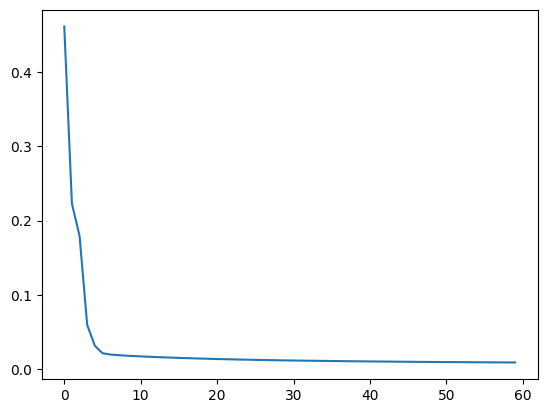

In [35]:
plt.plot(errors)

# Accuracy

In [36]:
def accuracy(y, gamma):
    '''
    Function to calculate accuracy
    '''
    acc_y = []
    for x in X_test:
        y = np.argmax(forward(x.reshape(1, 12), gamma)[-1])
        y = np.eye(gamma["nclasses"])[y]
        acc_y.append(y)

    acc_y = np.array(acc_y)
    wrong = len(np.where(np.equal(y_test, acc_y).astype(int) == 0)[0])
    return 1 - (len(y) / wrong)

In [37]:
print('Accuracy:{0:3d}%'.format(int(accuracy(y_train, gamma) * 100)))

Accuracy: 90%
